### Imports Needed
Seaborn plots are used mostly through this notebook

In [1]:
'''
Imports needed for the analysis work
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
sns.set()

### Load CPI Data
CPI data taken from http://www.econ.yale.edu/~shiller/data.htm <br>
The dataset has monthly CPI. Yearly CPI is calulated as mean of the monthly CPI.<br>
Also to convert revenue numbers and profit numbers to 2012 dollars, a conversion factor for each year is calculated using yearly CPI values

In [3]:
""" Note that only required columns taken in CSV format from the actual dataset"""
cpi_df = pd.read_csv("./data/CPI_data.csv", parse_dates=["Date"])
cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 4 columns):
Date          1773 non-null datetime64[ns]
CPI           1773 non-null float64
Adjusted      1770 non-null float64
Unnamed: 3    3 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 55.5 KB


In [4]:
""" Create the CPI Data Frame """
cpi_df = cpi_df[["Date", "CPI"]]
cpi_df["Year"] = cpi_df.Date.dt.year
cpi_df = cpi_df[cpi_df.Year.between(1955,2012, inclusive=True)]
cpi_df.reset_index(drop=True, inplace=True)
cpi_df = cpi_df.groupby("Year").mean()
cpi_df["Factor"] =  cpi_df.loc[2012,"CPI"] / cpi_df

cpi_df.sample(5)

,CPI,Factor
Year,,
1991,136.191667,1.685815
1955,26.775000,8.574936
1990,130.658333,1.757208
2009,214.537000,1.070183
2000,172.200000,1.333298


### Load the Fortune 500 Data
Scraped data is available as one CSV file per year containing 500 rows of Data. An R Utility program built for prior project is used to merge the data files into one singe CSV file. The R program is available along with this notebook in Github 

In [5]:
df = pd.read_csv("./data/processed/merged_data.csv", header = 0,
                 names=["Company", "DetailURL", "Profits", "Rank", "Revenue", "Self", "Year"],)
df.head(5)

,Company,DetailURL,Profits,Rank,Revenue,Self,Year
0,General Motors,https://money.cnn.com/magazines/fortune/fortun...,806.0,1.0,9823.5,https://money.cnn.com/magazines/fortune/fortun...,1955
1,Exxon Mobil,https://money.cnn.com/magazines/fortune/fortun...,584.8,2.0,5661.4,https://money.cnn.com/magazines/fortune/fortun...,1955
2,U.S. Steel,https://money.cnn.com/magazines/fortune/fortun...,195.4,3.0,3250.4,https://money.cnn.com/magazines/fortune/fortun...,1955
3,General Electric,https://money.cnn.com/magazines/fortune/fortun...,212.6,4.0,2959.1,https://money.cnn.com/magazines/fortune/fortun...,1955
4,Esmark,https://money.cnn.com/magazines/fortune/fortun...,19.1,5.0,2510.8,https://money.cnn.com/magazines/fortune/fortun...,1955


In [6]:
""" Drop columns not needed and additional Null rows in 2007 data"""
df.drop(["DetailURL", "Self"], axis=1, inplace=True)
df = df[df["Rank"].notnull()]
df["Company"] = df["Company"].map(str.strip)
df.head(5)

,Company,Profits,Rank,Revenue,Year
0,General Motors,806.0,1.0,9823.5,1955
1,Exxon Mobil,584.8,2.0,5661.4,1955
2,U.S. Steel,195.4,3.0,3250.4,1955
3,General Electric,212.6,4.0,2959.1,1955
4,Esmark,19.1,5.0,2510.8,1955


In [7]:
""" Data to rename company names where different name used between years"""

renames_df = pd.read_csv("./data/renames.csv")
renames_df["Name1"] = renames_df["Name1"].map(str.strip)
renames_df["Name2"] = renames_df["Name2"].map(str.strip)

In [8]:
for i in range(len(renames_df.index)):
    df.loc[df.Company == renames_df.iloc[i,0],"Company"] = renames_df.iloc[i,1]

df.head(5)

,Company,Profits,Rank,Revenue,Year
0,General Motors,806.0,1.0,9823.5,1955
1,Exxon Mobil,584.8,2.0,5661.4,1955
2,U.S. Steel,195.4,3.0,3250.4,1955
3,General Electric,212.6,4.0,2959.1,1955
4,Esmark,19.1,5.0,2510.8,1955


In [9]:
""" Merge the Scraped data with CPI data and create Adjusted Revenue and Profits  """ 
df2 = df.merge(cpi_df.reset_index())
df2["AdjRevenue"] = df2["Revenue"] * df2["Factor"]
df2["AdjProfits"] = df2["Profits"] * df2["Factor"]
df2["profitPercent"] = df2.Profits/df2.Revenue

"""Scale the revenue/profit values to be between [0, 1] using maximun revenue/profits achieved by the company
Simailarly, create an "Adjusted year column that start at 0 for every company the year it entered the list 
"""
df2 = df2.assign(AdjRevenueNorm = df2.AdjRevenue.div(df2.groupby("Company")["AdjRevenue"].transform("max")),
                 AdjProfitNorm = df2.AdjProfits.div(df2.groupby("Company")["AdjProfits"].transform("max")),
                 AdjYear = df2.Year - df2.groupby("Company")["Year"].transform("min"),
                )

df2 = df2.reset_index(drop=True)

df2.sample(5)

,Company,Profits,Rank,Revenue,Year,CPI,Factor,AdjRevenue,AdjProfits,profitPercent,AdjRevenueNorm,AdjProfitNorm,AdjYear
21846,LG&E Energy,97.8,347.0,4263.8,1998,163.008333,1.408480,6005.475437,137.749308,0.022937,0.788086,0.926010,1
8651,Hercules,55.1,152.0,811.9,1972,41.816667,5.490488,4457.727404,302.525902,0.067866,0.682193,0.189798,17
26888,Franklin Resources,1772.9,389.0,6205.8,2008,215.302500,1.066378,6617.730533,1890.582111,0.285684,0.926853,0.982835,2
10943,Hughes Tool,43.4,444.0,348.0,1976,56.908333,4.034452,1403.989158,175.095200,0.124713,0.335460,0.288377,0
16893,Allis-Chalmers,-29.0,394.0,699.0,1988,118.258333,1.941461,1357.081089,-56.302363,-0.041488,0.230021,-0.234175,33


In [10]:
df2["RevenueGrowth"] = df2.sort_values(["Year"]).groupby("Company")["AdjRevenue"].apply(lambda x: x.pct_change())
df2["ProfitGrowth"] = df2.sort_values(["Year"]).groupby("Company")["AdjProfits"].apply(lambda x: x.pct_change())

In [11]:
MIN_YEAR = df2.Year.min()
MAX_YEAR = df2.Year.max()
print(MIN_YEAR)
print(MAX_YEAR)

1955
2012


### Gather Data Points for each Company 
Data points for each company on when it entered the list, how long it has been in the list etc is collated here.
This dataframe is later used to merge with rest of the data later

In [12]:
grouped = df2.groupby("Company")
company_df = pd.DataFrame({"Company" : list(grouped.groups.keys()),
                        'MinRankYear' : grouped.apply(lambda x: x.loc[x["Rank"].idxmin(),"Year"]).values,
                        'MaxRankYear' : grouped.apply(lambda x: x.loc[x["Rank"].idxmax(),"Year"]).values,
                        'MinRank': grouped.apply(lambda x: x["Rank"].min()),
                        'MaxRank': grouped.apply(lambda x: x["Rank"].max()),
                        "FirstYearInList" : grouped.first()["Year"],
                        "LastYearInList" : grouped.last()["Year"],
                        "MinRevenue": grouped.apply(lambda x: x["Revenue"].min()),
                        "MaxRevenue": grouped.apply(lambda x: x["Revenue"].max()),
                        "MinYearRevenue": grouped.apply(lambda x: x.loc[x["Rank"].idxmin(),"AdjRevenue"]).values,
                        "MaxYearRevenue": grouped.apply(lambda x: x.loc[x["Rank"].idxmax(),"AdjRevenue"]).values,
                        "MinProfit": grouped.apply(lambda x: x["Profits"].min()),
                        "MaxProfit": grouped.apply(lambda x: x["Profits"].max()),
                        "MinYearProfit": grouped.apply(lambda x: x.loc[x["Rank"].idxmin(),"AdjProfits"]).values,
                        "MaxYearProfit": grouped.apply(lambda x: x.loc[x["Rank"].idxmax(),"AdjProfits"]).values                        
                      })

company_df["InTheList"] = company_df["LastYearInList"] == MAX_YEAR
company_df["NoOfYearsInList"] = company_df["LastYearInList"] - company_df["FirstYearInList"] +1

company_df["NoOfYearsBucket"] = company_df.NoOfYearsInList.map(lambda x: str((x//5)*5 + 1).zfill(2) 
                                                           + "-" + str((x//5)*5+5).zfill(2))

company_df.head(5)

,Company,MinRankYear,MaxRankYear,MinRank,MaxRank,FirstYearInList,LastYearInList,MinRevenue,MaxRevenue,MinYearRevenue,MaxYearRevenue,MinProfit,MaxProfit,MinYearProfit,MaxYearProfit,InTheList,NoOfYearsInList,NoOfYearsBucket
Company,,,,,,,,,,,,,,,,,,
3Com,3Com,2000,1994,294.0,496.0,1994,2001,617.2,5772.1,7695.929422,956.015283,30.2,674.3,538.519065,59.789679,False,8,06-10
3M,3M,1993,1955,28.0,131.0,1955,2012,230.9,29611.0,22064.856153,1979.952768,24.6,4283.0,1959.660566,210.943430,True,58,56-60
A-T-O,A-T-O,1970,1968,258.0,321.0,1968,1971,242.3,378.9,2240.647393,1599.346603,2.1,10.7,63.275078,60.726326,False,4,01-05
A. Schulman,A. Schulman,1992,1988,414.0,498.0,1988,1994,464.0,740.1,1210.992691,900.837804,20.0,43.8,69.213607,38.829216,False,7,06-10
A.H. Robins,A.H. Robins,1989,1983,346.0,462.0,1983,1989,482.3,934.0,1729.825637,1111.778574,-1632.0,81.8,107.419579,112.261283,False,7,06-10


In [13]:
full_data_df = pd.merge(df2, company_df.reset_index(drop=True),on="Company", how="left")
full_data_df.head(5)

,Company,Profits,Rank,Revenue,Year,CPI,Factor,AdjRevenue,AdjProfits,profitPercent,...,MaxRevenue,MinYearRevenue,MaxYearRevenue,MinProfit,MaxProfit,MinYearProfit,MaxYearProfit,InTheList,NoOfYearsInList,NoOfYearsBucket
0,General Motors,806.0,1.0,9823.5,1955,26.775,8.574936,84235.885728,6911.398575,0.082048,...,207349.0,84235.885728,110123.331676,-38732.0,9190.0,6911.398575,NaN,True,58,56-60
1,Exxon Mobil,584.8,2.0,5661.4,1955,26.775,8.574936,48546.143784,5014.622688,0.103296,...,452926.0,179442.897623,138792.847826,562.5,45220.0,13405.326819,8779.908445,True,58,56-60
2,U.S. Steel,195.4,3.0,3250.4,1955,26.775,8.574936,27871.972614,1675.542533,0.060116,...,13940.5,27871.972614,31543.691684,-293.0,1077.2,1675.542533,1273.908507,False,28,26-30
3,General Electric,212.6,4.0,2959.1,1955,26.775,8.574936,25374.093700,1823.031435,0.071846,...,183207.0,25374.093700,64809.723212,200.1,22208.0,1823.031435,3930.457516,True,58,56-60
4,Esmark,19.1,5.0,2510.8,1955,26.775,8.574936,21529.949803,163.781281,0.007607,...,6743.2,21529.949803,7898.506576,-41.6,471.8,163.781281,223.170045,False,30,31-35


In [14]:
number_of_years = company_df["NoOfYearsInList"].value_counts().reset_index()
number_of_years.columns = ["NoOfYears", "Count"]
number_of_years.head(5)

,NoOfYears,Count
0,1,206
1,2,155
2,18,135
3,3,134
4,4,122


In [15]:
number_of_years_buckets = company_df["NoOfYearsBucket"].value_counts().reset_index()
number_of_years_buckets.columns = ["NoOfYears", "Count"]
number_of_years_buckets = number_of_years_buckets.sort_values(["NoOfYears"])
number_of_years_buckets.head()

,NoOfYears,Count
0,01-05,617
1,06-10,398
2,11-15,288
3,16-20,252
6,21-25,78


In [16]:
added_companies_by_year = company_df["FirstYearInList"].value_counts().reset_index()
added_companies_by_year.columns = ["Year", "Count"]
added_companies_by_year = added_companies_by_year.sort_values(["Year"])
added_companies_by_year.head()

,Year,Count
0,1955,499
3,1956,39
22,1957,26
20,1958,27
23,1959,24


In [17]:
overall_stats = full_data_df.groupby("Year").mean().reset_index()

In [18]:
YearCompanies_15 = company_df[(company_df["NoOfYearsInList"] == 15) & (company_df["InTheList"]==False)].Company
sample_year15 = YearCompanies_15.sample(15, replace=False)
year_15_df = full_data_df[full_data_df.Company.isin(sample_year15)]
year_15_df.shape

(211, 32)

In [19]:
by_bucket = full_data_df.groupby(["AdjYear","NoOfYearsBucket", "InTheList"]).mean()
by_bucket = by_bucket.reset_index()

In [20]:
by_year = full_data_df.groupby(["Year", "InTheList"]).mean().reset_index()

In [21]:
by_bucket_2012 = full_data_df.groupby(["AdjYear","NoOfYearsBucket"]).mean().reset_index()

In [22]:
by_11to15_2012 = full_data_df[(full_data_df.NoOfYearsBucket == "11-15") & (full_data_df.InTheList == True)]
temp_companies = pd.Series(by_11to15_2012.Company.unique()).sample(9)
by_11to15_2012 = by_11to15_2012[by_11to15_2012.Company.isin(temp_companies)]

In [23]:
by_6to10_2012 = full_data_df[(full_data_df.NoOfYearsBucket == "06-10") & (full_data_df.InTheList == True)]
temp_companies = pd.Series(by_6to10_2012.Company.unique()).sample(9)
by_6to10_2012 = by_6to10_2012[by_6to10_2012.Company.isin(temp_companies)]

In [24]:
by_11to15_1995 = full_data_df[(full_data_df.NoOfYearsBucket == "11-15") & (full_data_df.Year == 1995)]
temp_companies = pd.Series(by_11to15_1995.Company.unique())
by_11to15_1995 = full_data_df[full_data_df.Company.isin(temp_companies)]

by_11to15_1995 = by_11to15_1995.groupby(["Company","AdjYear"]).mean().reset_index()

In [25]:
by_11to15_1985 = full_data_df[(full_data_df.NoOfYearsBucket == "11-15") & (full_data_df.Year == 1985)]
temp_companies = pd.Series(by_11to15_1985.Company.unique())
by_11to15_1985 = full_data_df[full_data_df.Company.isin(temp_companies)]

by_11to15_1985 = by_11to15_1985.groupby(["Company","AdjYear"]).mean().reset_index()

### Observation
#### A quick look at what made the top 20 in 2012

In [26]:
full_data_df[full_data_df.Year == 2012][["Company", "AdjRevenue", "AdjProfits"]].\
        sort_values(["AdjRevenue"], ascending = False).head(20)

,Company,AdjRevenue,AdjProfits
28500,Exxon Mobil,452926.0,41060.0
28501,Wal-Mart Stores,446950.0,15699.0
28502,Chevron,245621.0,26895.0
28503,ConocoPhillips,237272.0,12436.0
28504,General Motors,150276.0,9190.0
28505,General Electric,147616.0,14151.0
28506,Berkshire Hathaway,143688.0,10254.0
28507,Fannie Mae,137451.0,-16855.0
28508,Ford Motor,136264.0,20213.0
28509,Hewlett-Packard,127245.0,7074.0


### Observation
#### How about longivity of these top 20? The top 20 companies from 2012 list have been in the Fortune 500 for a while

In [27]:
full_data_df[full_data_df.Year == 2012][["Company", "AdjRevenue", "AdjProfits", "NoOfYearsInList"]].\
            sort_values(["AdjRevenue"], ascending = False).head(20)

,Company,AdjRevenue,AdjProfits,NoOfYearsInList
28500,Exxon Mobil,452926.0,41060.0,58
28501,Wal-Mart Stores,446950.0,15699.0,18
28502,Chevron,245621.0,26895.0,58
28503,ConocoPhillips,237272.0,12436.0,58
28504,General Motors,150276.0,9190.0,58
28505,General Electric,147616.0,14151.0,58
28506,Berkshire Hathaway,143688.0,10254.0,57
28507,Fannie Mae,137451.0,-16855.0,18
28508,Ford Motor,136264.0,20213.0,57
28509,Hewlett-Packard,127245.0,7074.0,51


### Observation
#### But if we look at number of companies per length of time in the list (1 Year, 2 Year etc) we can see a lot many companies make it to the list and vanish in few years

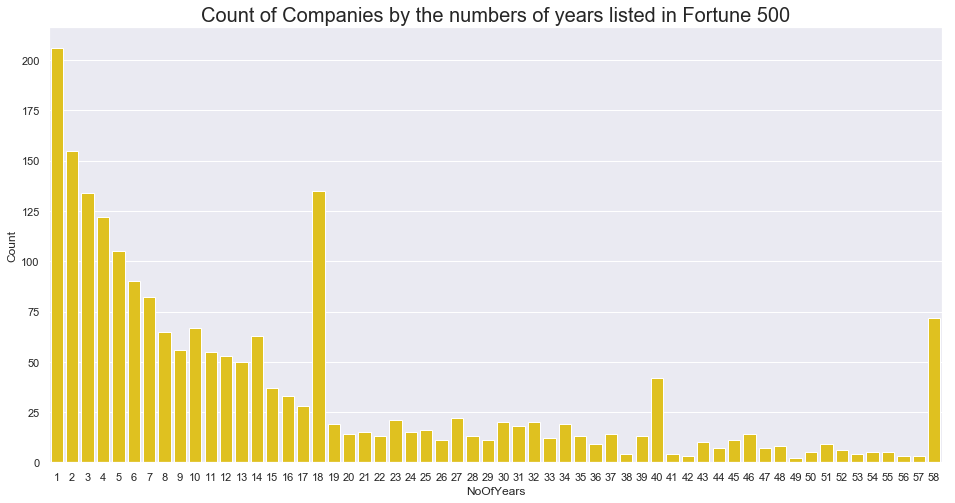

In [28]:
plt.figure(figsize=(16,8))
_ = sns.barplot(number_of_years.NoOfYears, number_of_years.Count, color="gold")\
    .set_title("Count of Companies by the numbers of years listed in Fortune 500", fontsize=20)

### Observation
#### Same as above organized in 5 year bins 

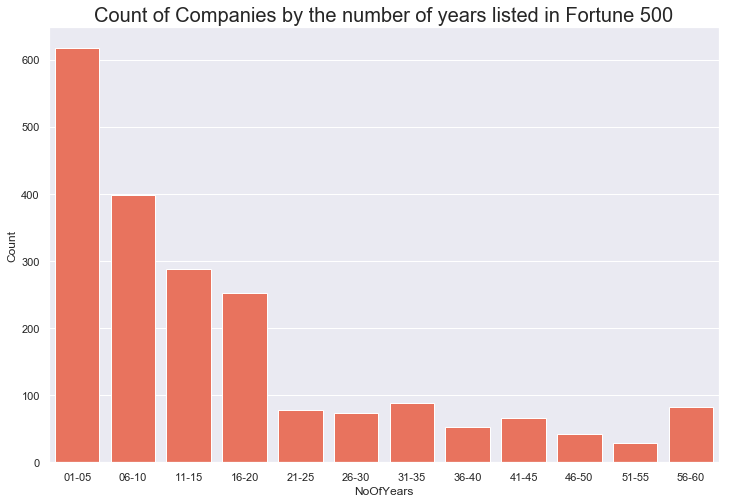

In [29]:
plt.figure(figsize=(12,8))
_ = sns.barplot(number_of_years_buckets.NoOfYears, number_of_years_buckets.Count, color = "tomato")\
        .set_title("Count of Companies by the number of years listed in Fortune 500", fontsize=20)

### Observation
#### On Average there is 5% to 10% churn in the companies listed in Fortune 500. Mergers and splits could be some part of the reason
Note: 1995 seems to be exception where Fotune seem to have changed the criteria or something. We can also see in later charts that, this change impacted revenue/profits beyond this point  

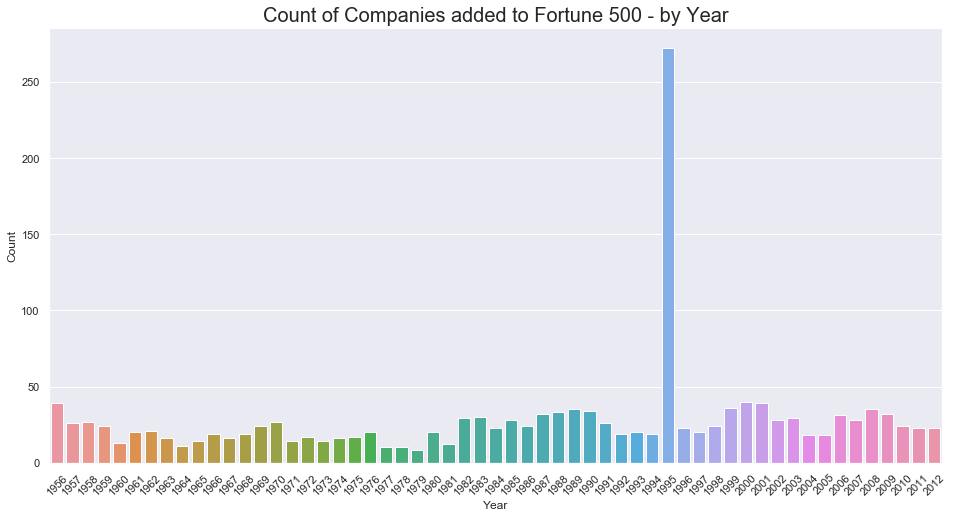

In [30]:
plt.figure(figsize=(16,8))
g = sns.barplot(added_companies_by_year.Year[1:], added_companies_by_year.Count[1:])\
        .set_title("Count of Companies added to Fortune 500 - by Year", fontsize=20)
loc, labels = plt.xticks(rotation=45)


### Observation
#### Let us look at how the Fortune 500 companies did on average over years. 
#### While CPI has raisen about 8 - 9 times, Revenue and Income for companies in the Fortune 500 list has grown faster 

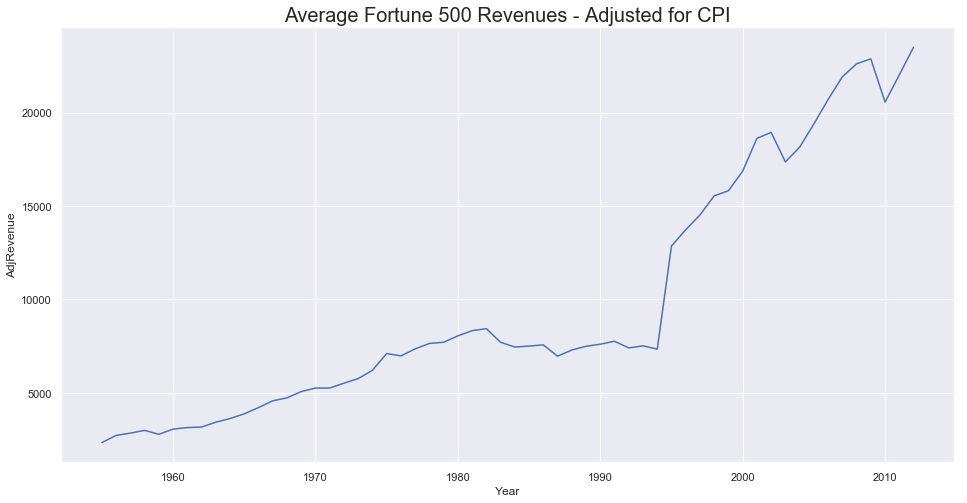

In [31]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="Year", y="AdjRevenue", data=overall_stats)\
        .set_title("Average Fortune 500 Revenues - Adjusted for CPI", fontsize=20)



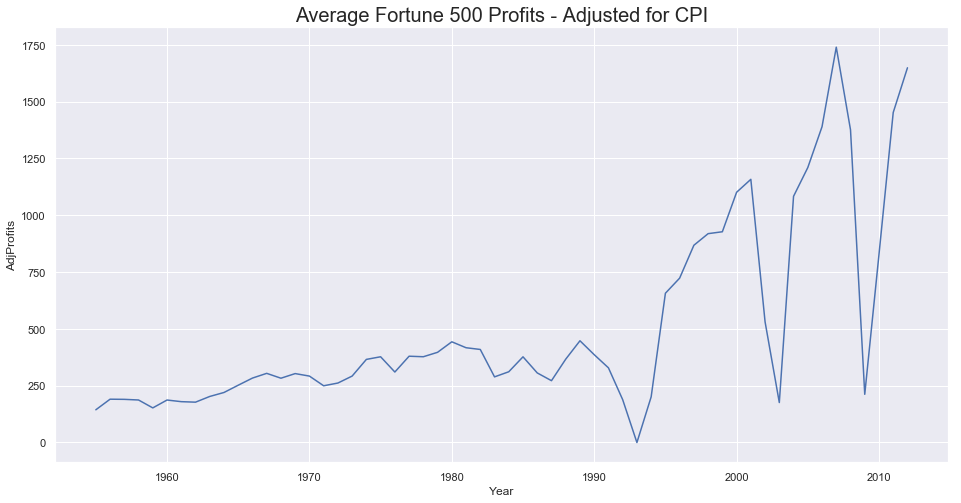

In [32]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="Year", y="AdjProfits", data=overall_stats)\
                .set_title("Average Fortune 500 Profits - Adjusted for CPI", fontsize=20)

### Observation
#### But we can see the contrast between the companies that survived and the companies taken out of the list

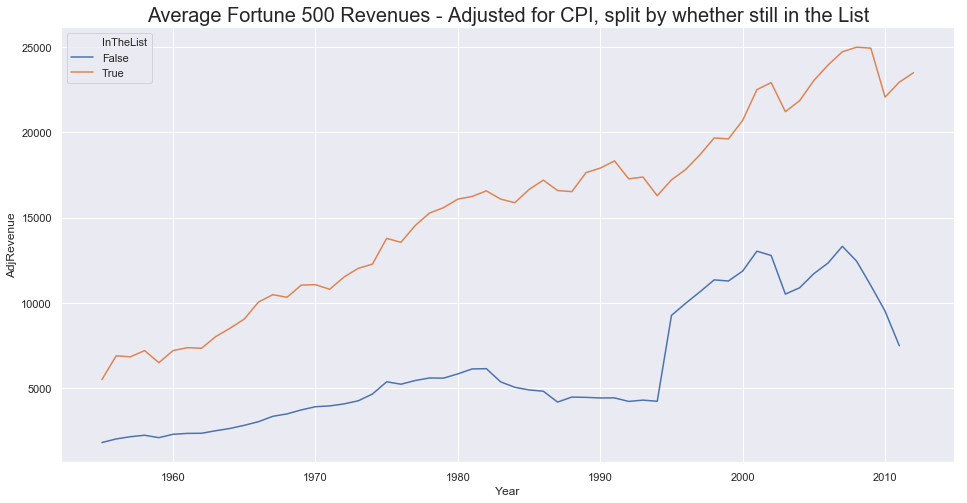

In [33]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="Year", y="AdjRevenue" ,hue="InTheList", data=by_year)\
                .set_title("Average Fortune 500 Revenues - Adjusted for CPI, split by whether still in the List", \
                           fontsize=20)

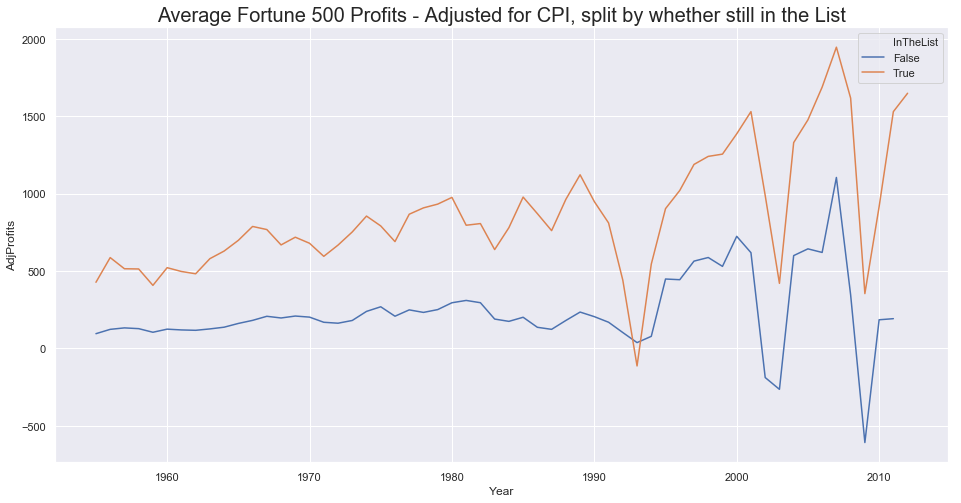

In [34]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="Year", y="AdjProfits" ,hue="InTheList", data=by_year)\
.set_title("Average Fortune 500 Profits - Adjusted for CPI, split by whether still in the List", \
                           fontsize=20)

### Observation
#### Profits are either stagnant or declining for companies that got delisted. 

(-0.4, 0.7)

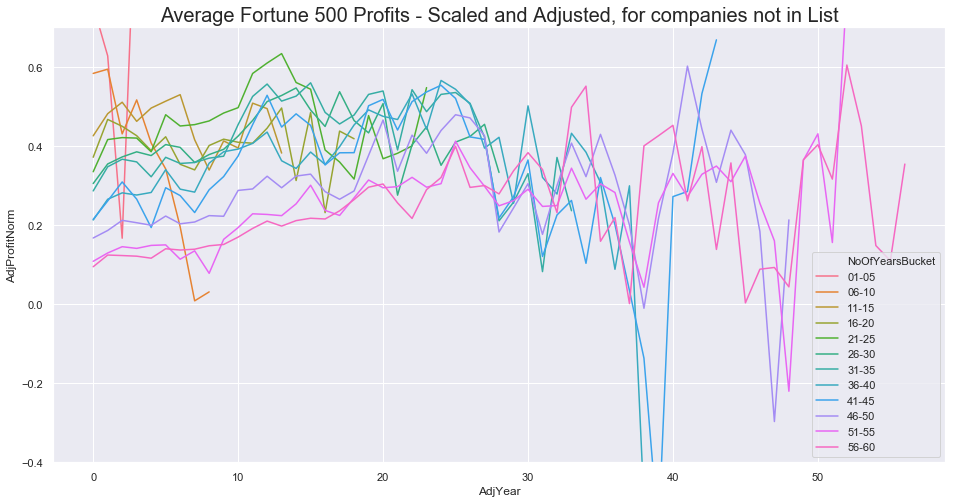

In [35]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="AdjYear", y="AdjProfitNorm" , hue = "NoOfYearsBucket", data=by_bucket[by_bucket.InTheList == False])\
        .set_title("Average Fortune 500 Profits - Scaled and Adjusted, for companies not in List", \
                           fontsize=20)
plt.ylim(-0.4, 0.7)

### Observation
#### Profits have upward trend for companies still in the list, some close to the top

(-0.5, 1.25)

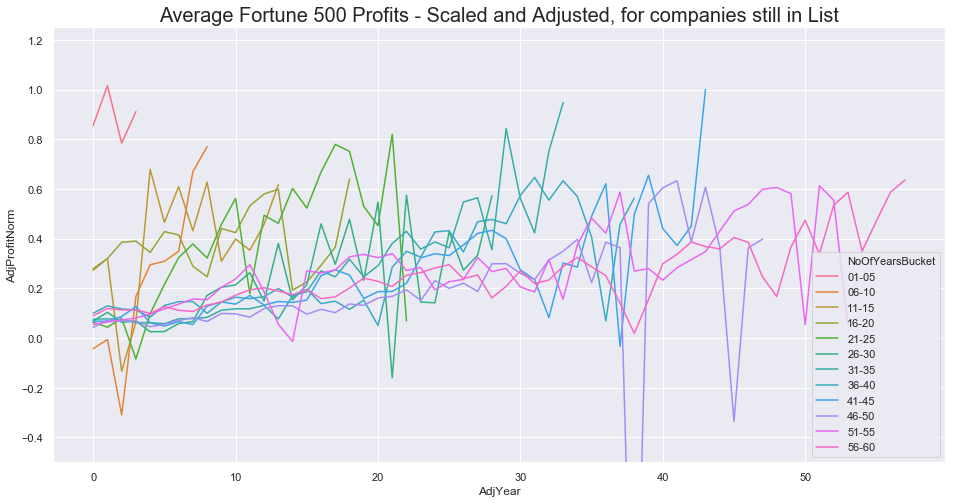

In [36]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="AdjYear", y="AdjProfitNorm" , hue = "NoOfYearsBucket", data=by_bucket[by_bucket.InTheList == True])\
        .set_title("Average Fortune 500 Profits - Scaled and Adjusted, for companies still in List", \
                           fontsize=20)
plt.ylim(-0.5, 1.25)

(-0.2, 0.4)

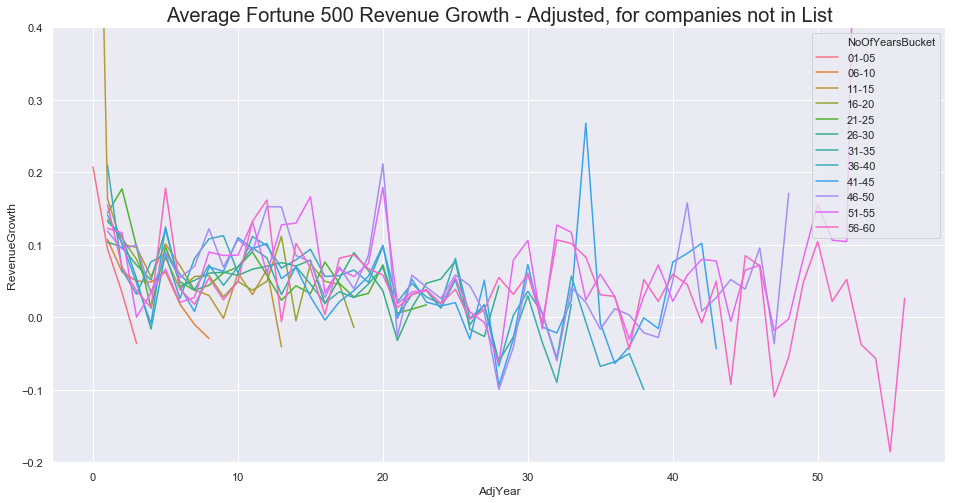

In [37]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="AdjYear", y="RevenueGrowth" , hue = "NoOfYearsBucket", data=by_bucket[by_bucket.InTheList == False])\
        .set_title("Average Fortune 500 Revenue Growth - Adjusted, for companies not in List", \
                           fontsize=20)
plt.ylim(-0.2,0.4)

(-0.2, 1)

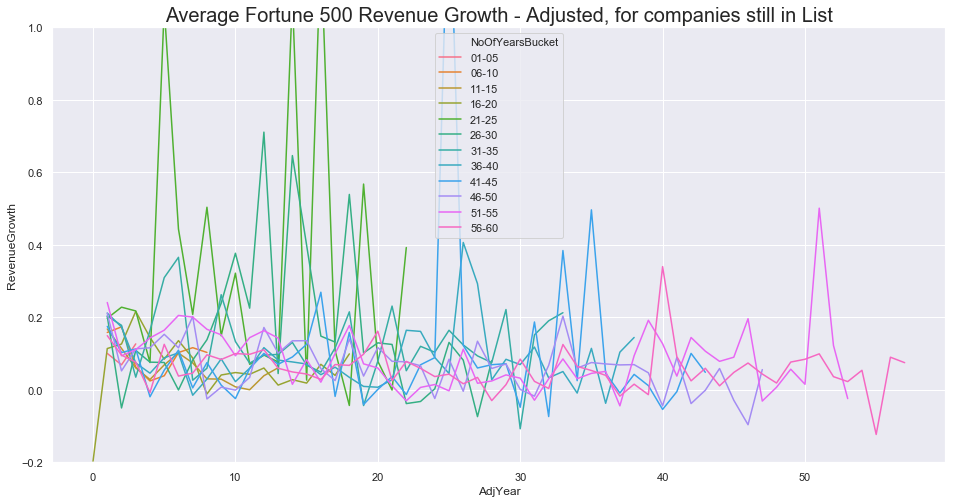

In [38]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="AdjYear", y="RevenueGrowth" , hue = "NoOfYearsBucket", data=by_bucket[by_bucket.InTheList == True])\
        .set_title("Average Fortune 500 Revenue Growth - Adjusted, for companies still in List", \
                           fontsize=20)
plt.ylim(-0.2,1)

Text(0.5,0.98,'Average Fortune 500 Revenue Growth - Adjusted, for companies not in List')

<Figure size 1152x576 with 0 Axes>

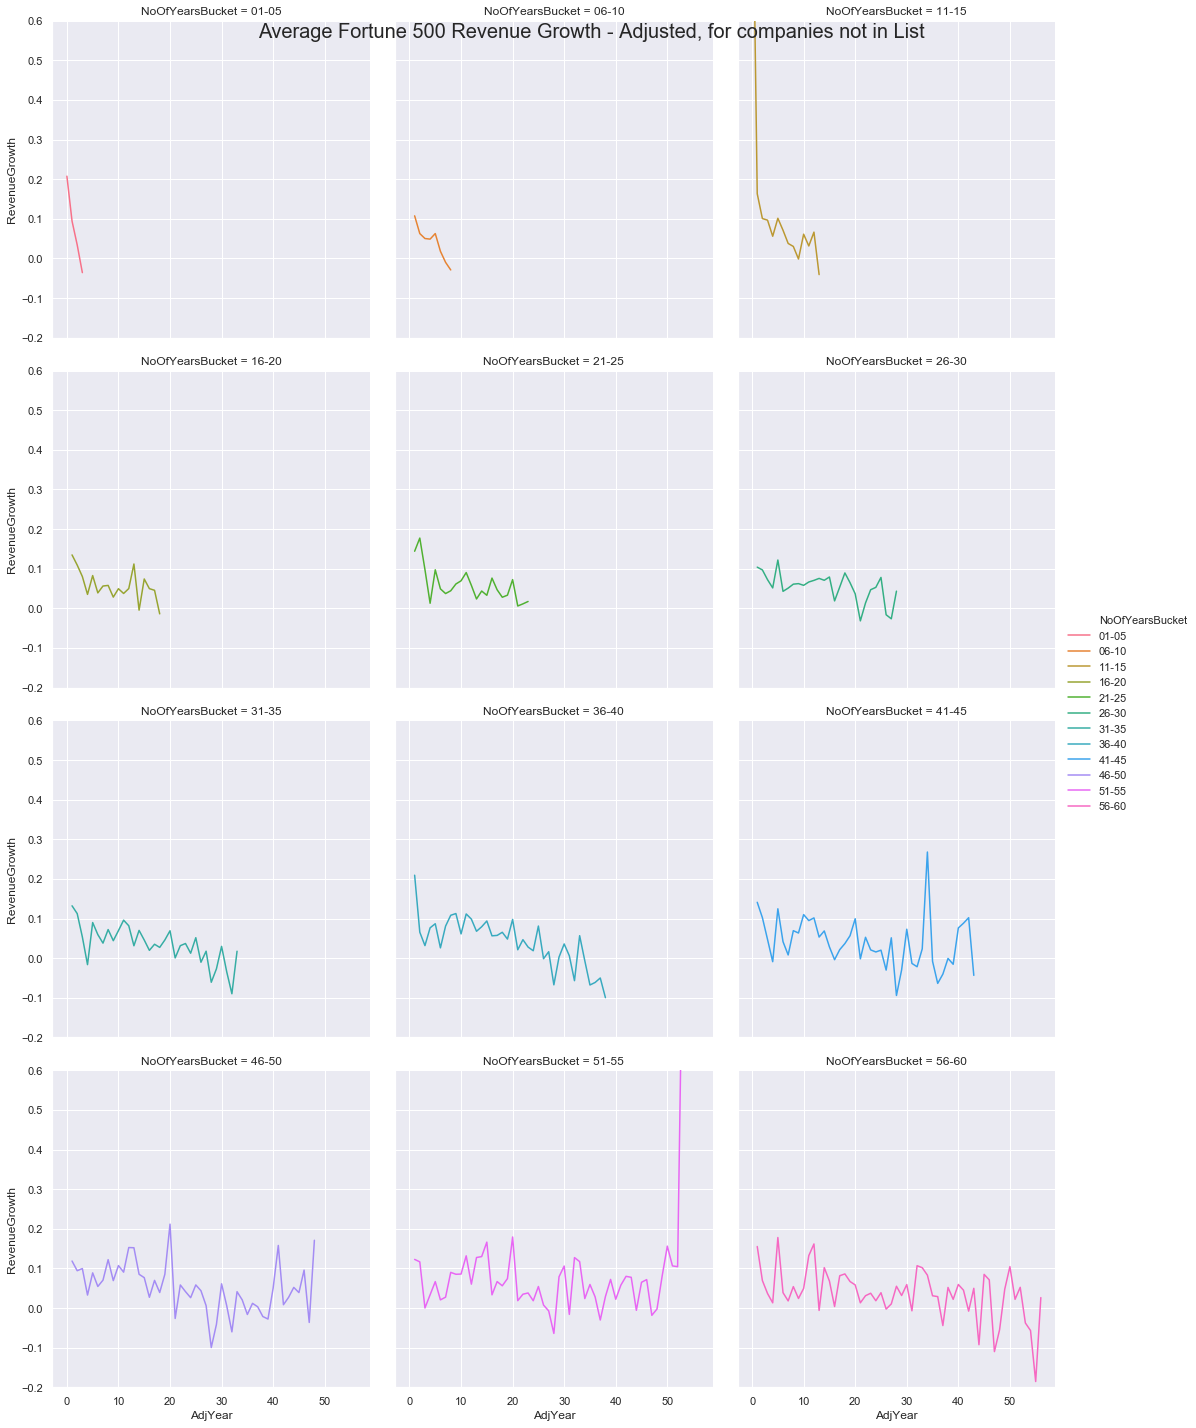

In [39]:
plt.figure(figsize=(16,8))
g = sns.relplot(x="AdjYear", y="RevenueGrowth" , col = "NoOfYearsBucket", hue = "NoOfYearsBucket", \
                col_wrap=3, kind="line", data=by_bucket[by_bucket.InTheList == False])
plt.ylim(-0.2,0.6)
g.fig.suptitle("Average Fortune 500 Revenue Growth - Adjusted, for companies not in List", fontsize=20)

(-0.2, 0.6)

<Figure size 1152x576 with 0 Axes>

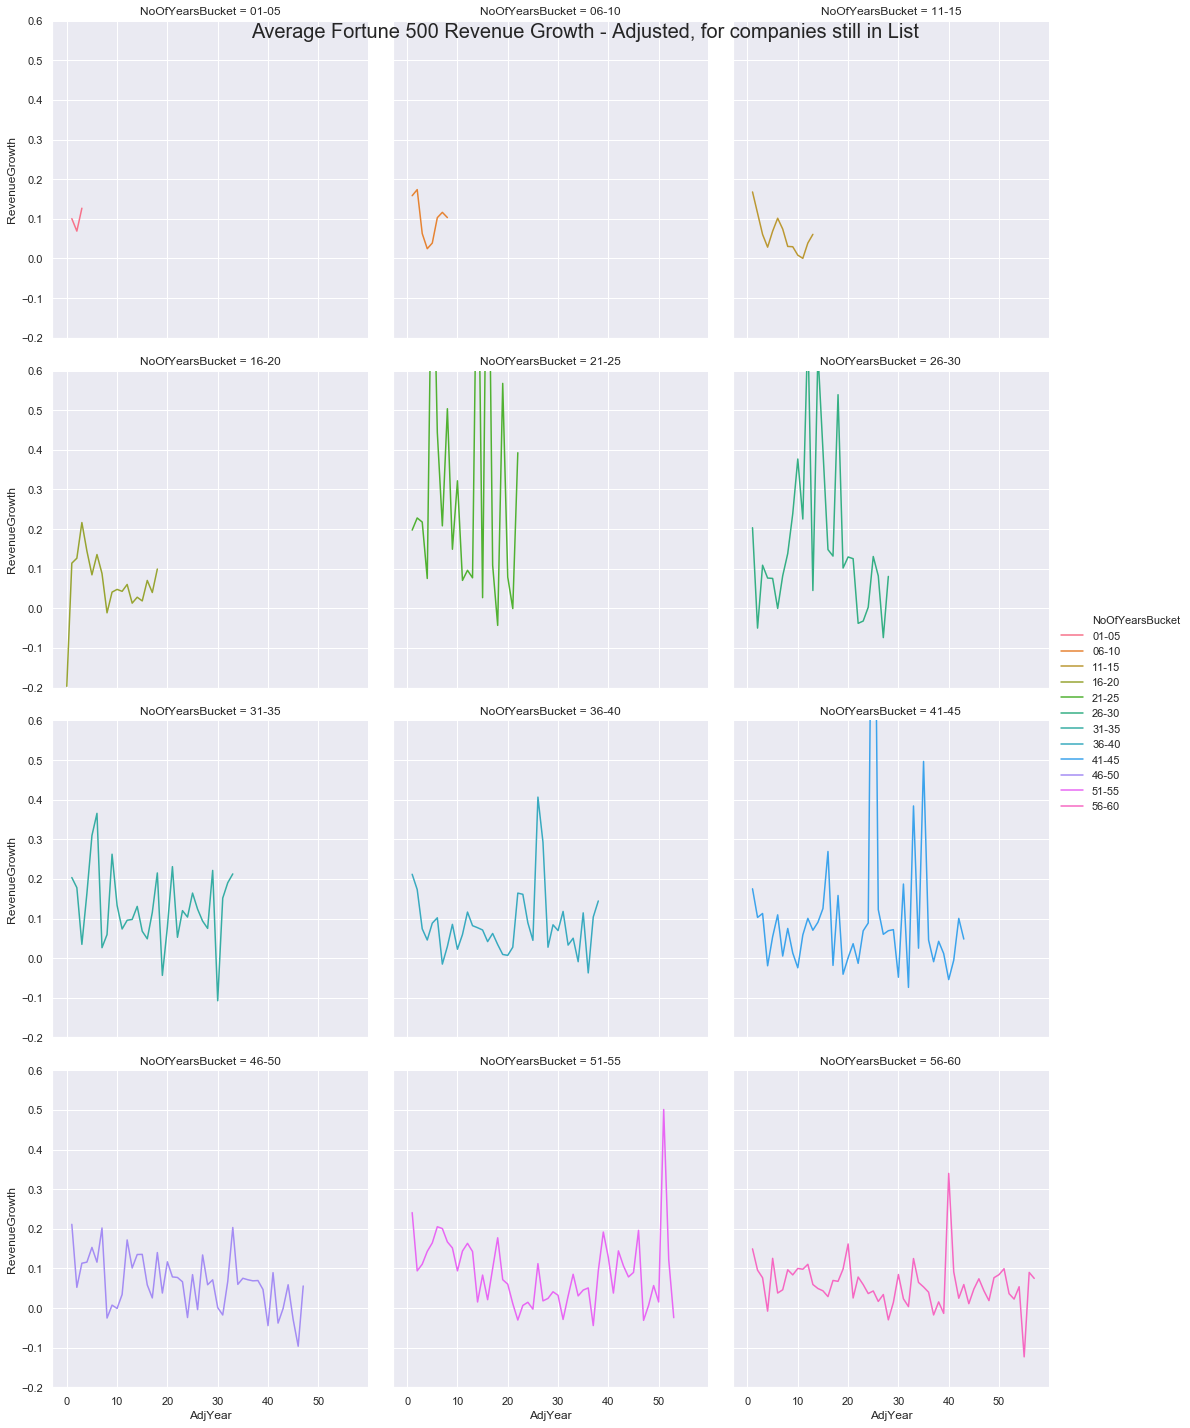

In [40]:

plt.figure(figsize=(16,8))
g = sns.relplot(x="AdjYear", y="RevenueGrowth" , col = "NoOfYearsBucket", hue = "NoOfYearsBucket",
            col_wrap=3, kind="line", data=by_bucket[by_bucket.InTheList == True])
g.fig.suptitle("Average Fortune 500 Revenue Growth - Adjusted, for companies still in List", fontsize=20)
plt.ylim(-0.2,0.6)

### Observation
#### As a more concrete example, let us look at a sample list of companies (15 randomly selected) 

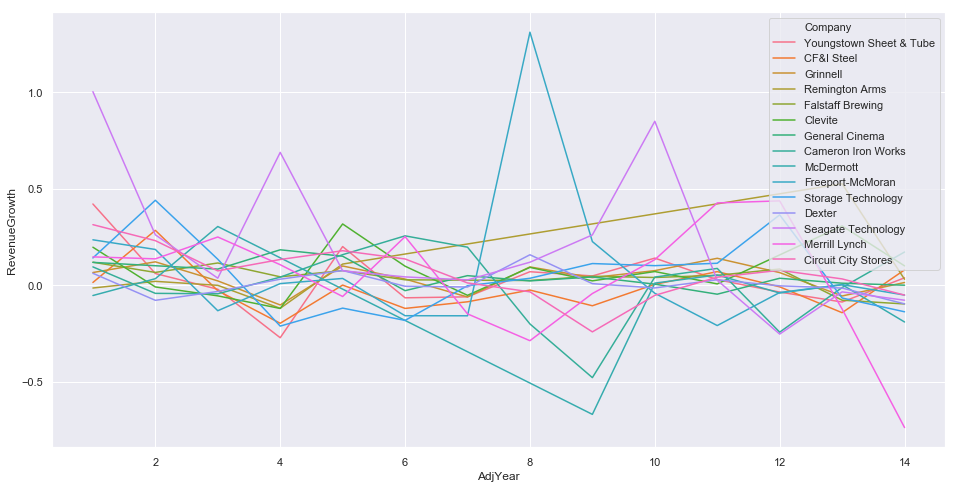

In [41]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="AdjYear", y="RevenueGrowth", hue="Company", data=year_15_df)

Text(0.5,0.98,'Growth Rates of 15 companies that stayed in Fortune 500 for 15 Years')

<Figure size 1152x576 with 0 Axes>

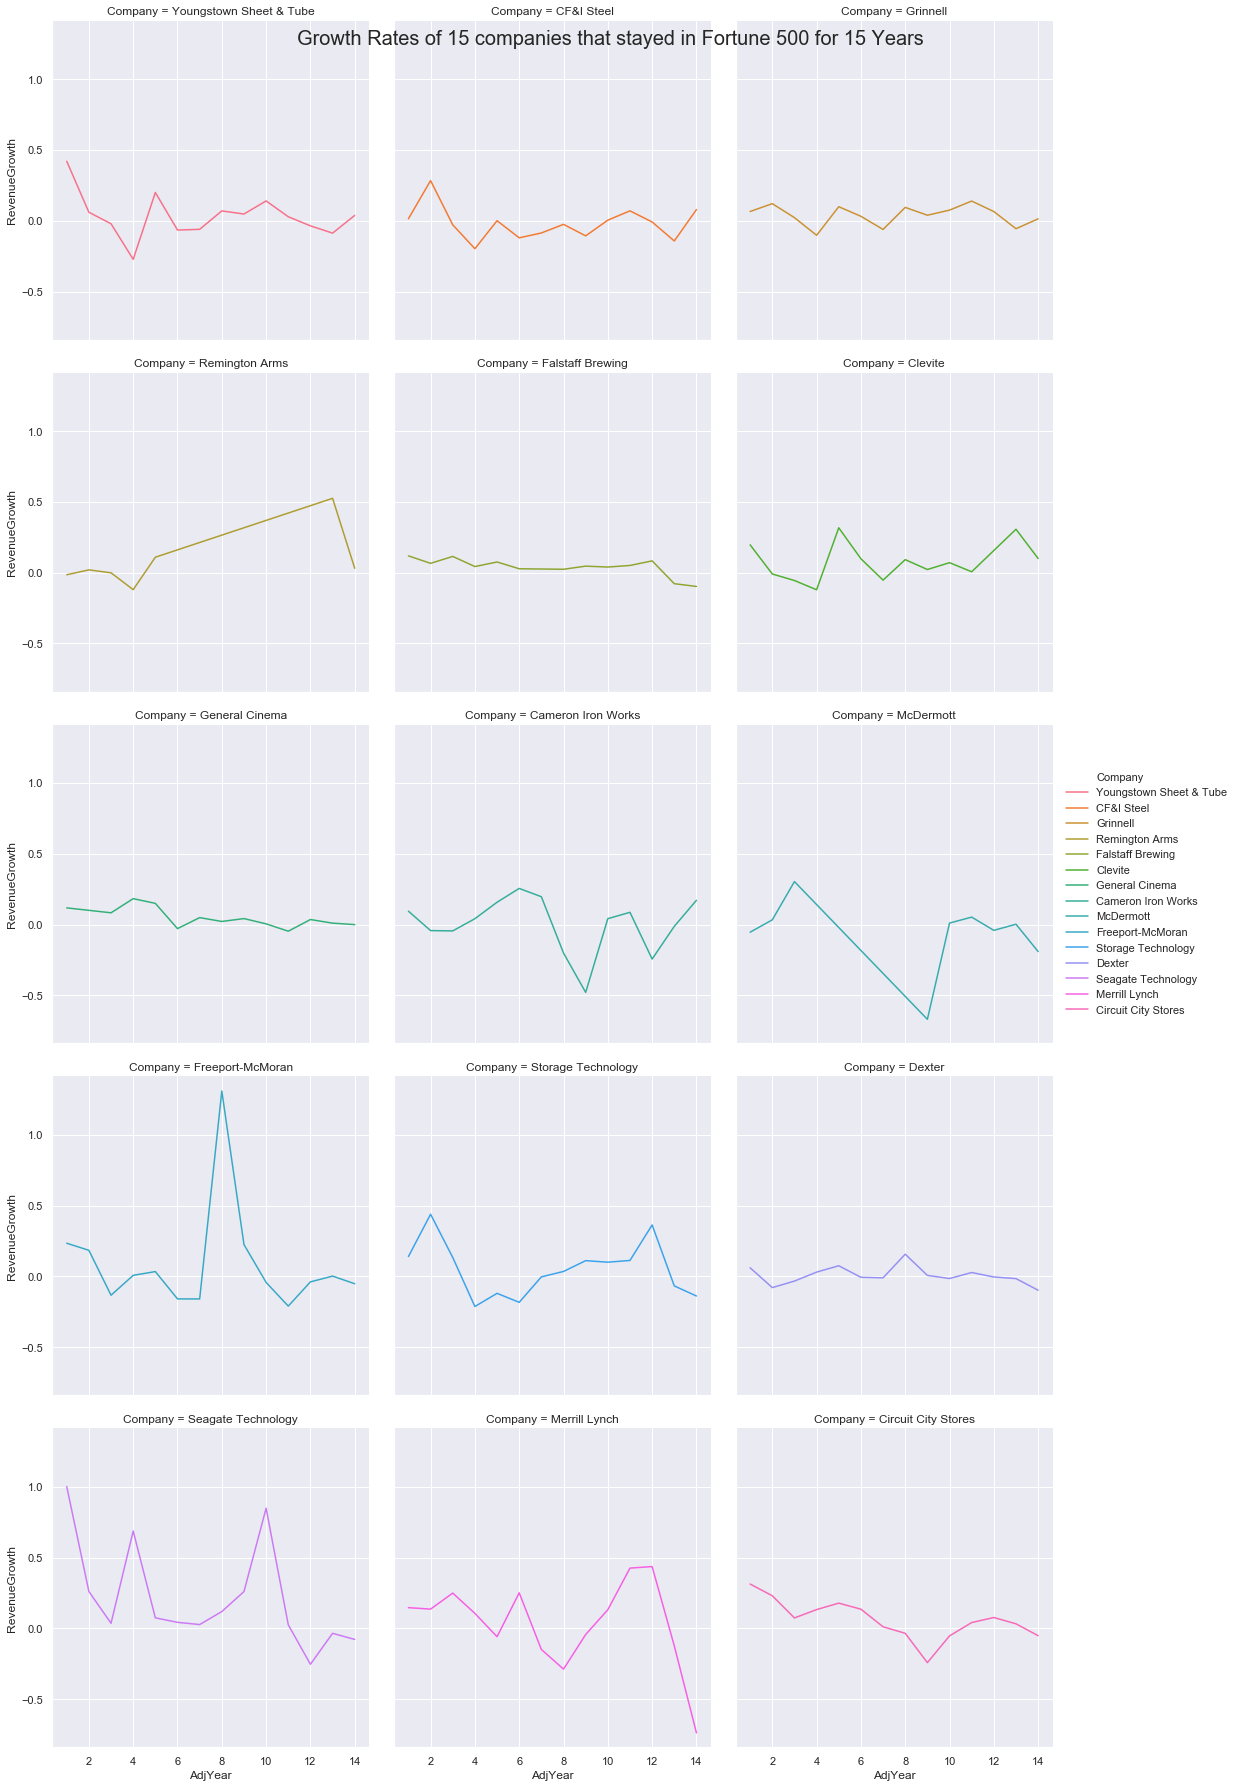

In [42]:
plt.figure(figsize=(16,8))
g = sns.relplot(x="AdjYear", y="RevenueGrowth", hue="Company", col="Company", col_wrap=3, data=year_15_df, kind = "line")

g.fig.suptitle("Growth Rates of 15 companies that stayed in Fortune 500 for 15 Years", fontsize=20)

### Observation
#### Looking at growth rates for all companies still in Fortune 500, younger companies have hight growt rates on average. Note that, there was "Great Recession of 2008" during this time.

Text(0.5,0.98,'Revenue Growth - for companies still in Fortune 500')

<Figure size 1152x576 with 0 Axes>

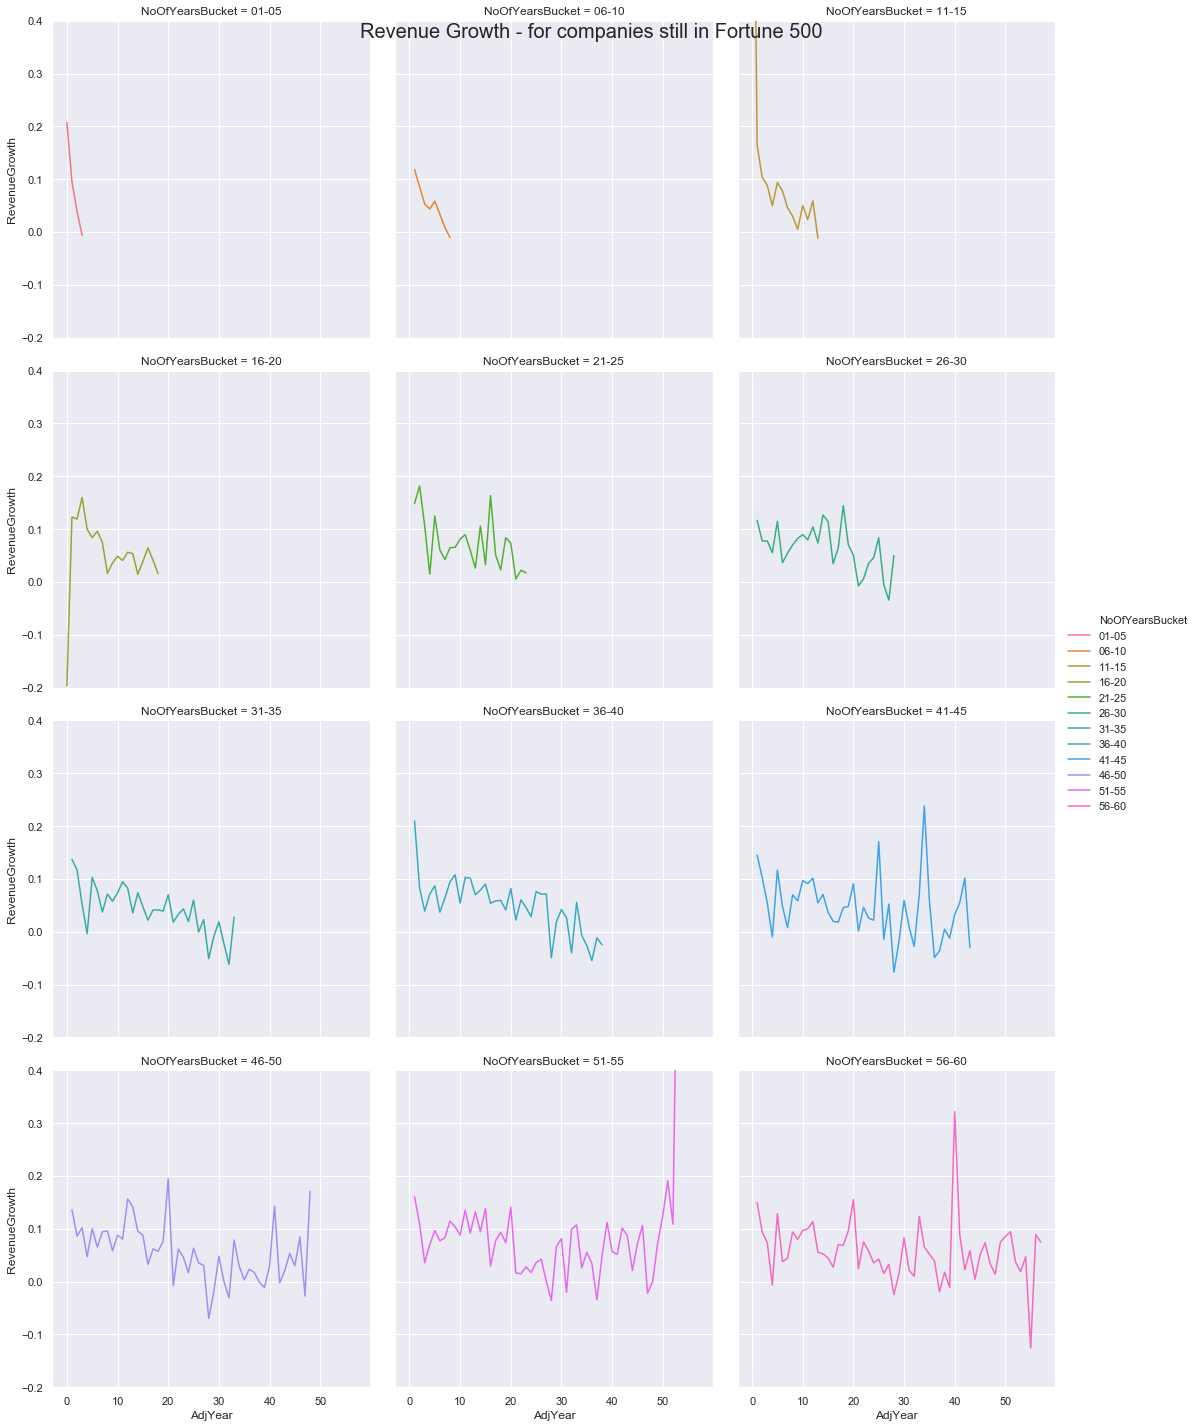

In [43]:
plt.figure(figsize=(16,8))
g = sns.relplot(x="AdjYear", y="RevenueGrowth", hue="NoOfYearsBucket", col="NoOfYearsBucket", col_wrap=3, data=by_bucket_2012, kind = "line")
plt.ylim(-0.2,0.4)
g.fig.suptitle("Revenue Growth - for companies still in Fortune 500", fontsize=20)

### Observation
#### To be specific, looking at growth rates for sample set companies that have age between 11 and 15 and still in the list, we can notice, high growth rates. Note that, there was "Great Recession of 2008" during this time.

Text(0.5,0.98,'Revenue Growth for 9 Sample Companies that lasted between 11-15 years, still in list ')

<Figure size 1152x576 with 0 Axes>

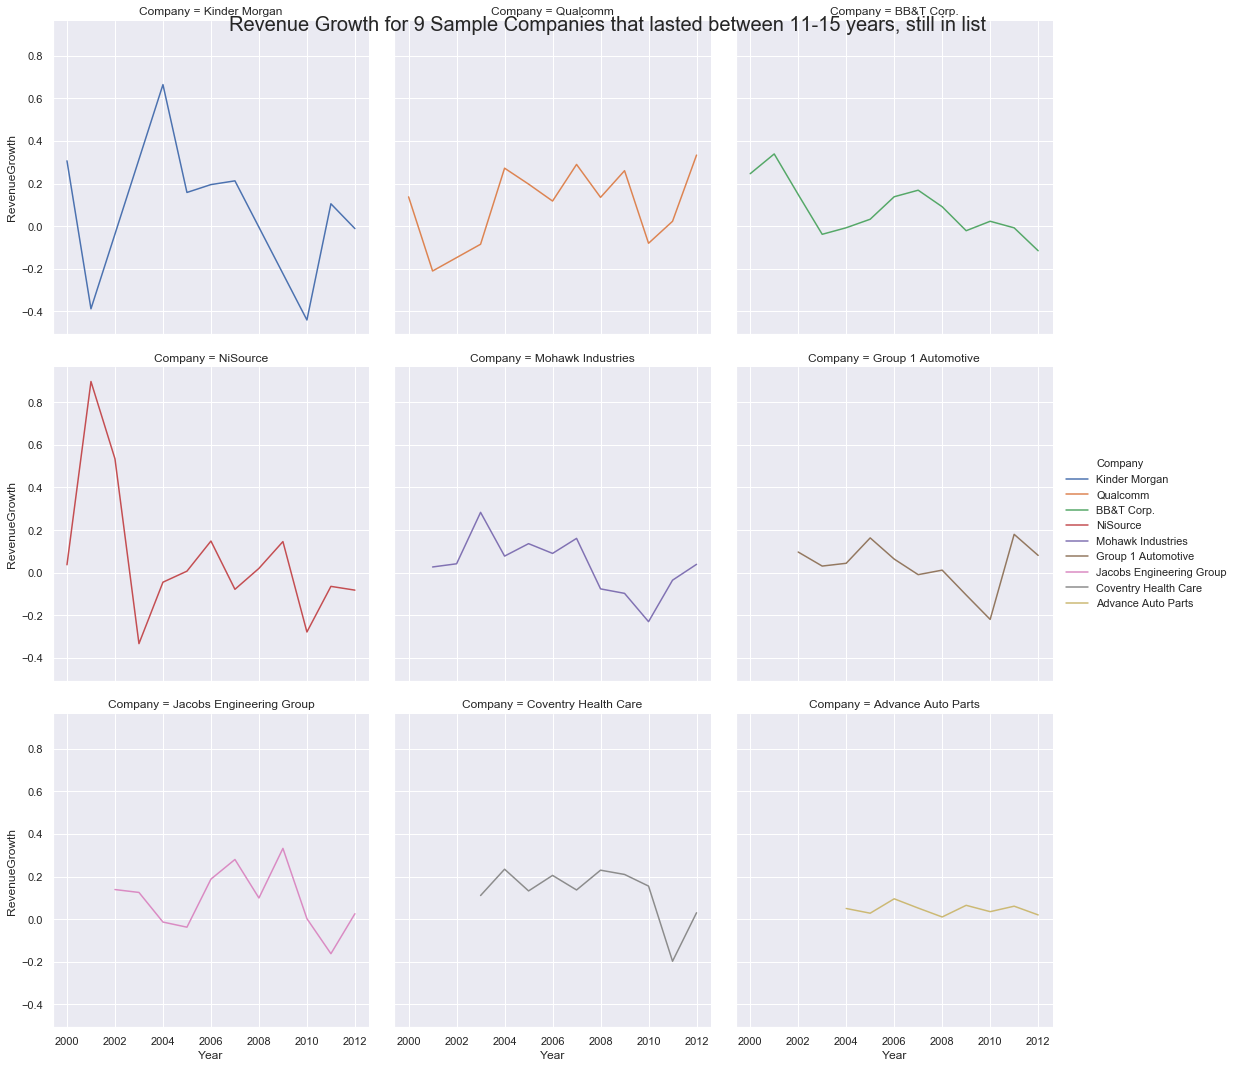

In [44]:
plt.figure(figsize=(16,8))
g = sns.relplot(x="Year", y="RevenueGrowth", hue="Company", col="Company", col_wrap=3, data=by_11to15_2012, kind = "line")
g.fig.suptitle("Revenue Growth for 9 Sample Companies that lasted between 11-15 years, still in list ", fontsize=20)


### Observation
#### To be specific, looking at growth rates for companies that have age between 6 and 10 and still in the list, we can notice volatile, but high growth rates. Note that, there was "Great Recession of 2008" during this time.

(-1, 1)

<Figure size 1152x576 with 0 Axes>

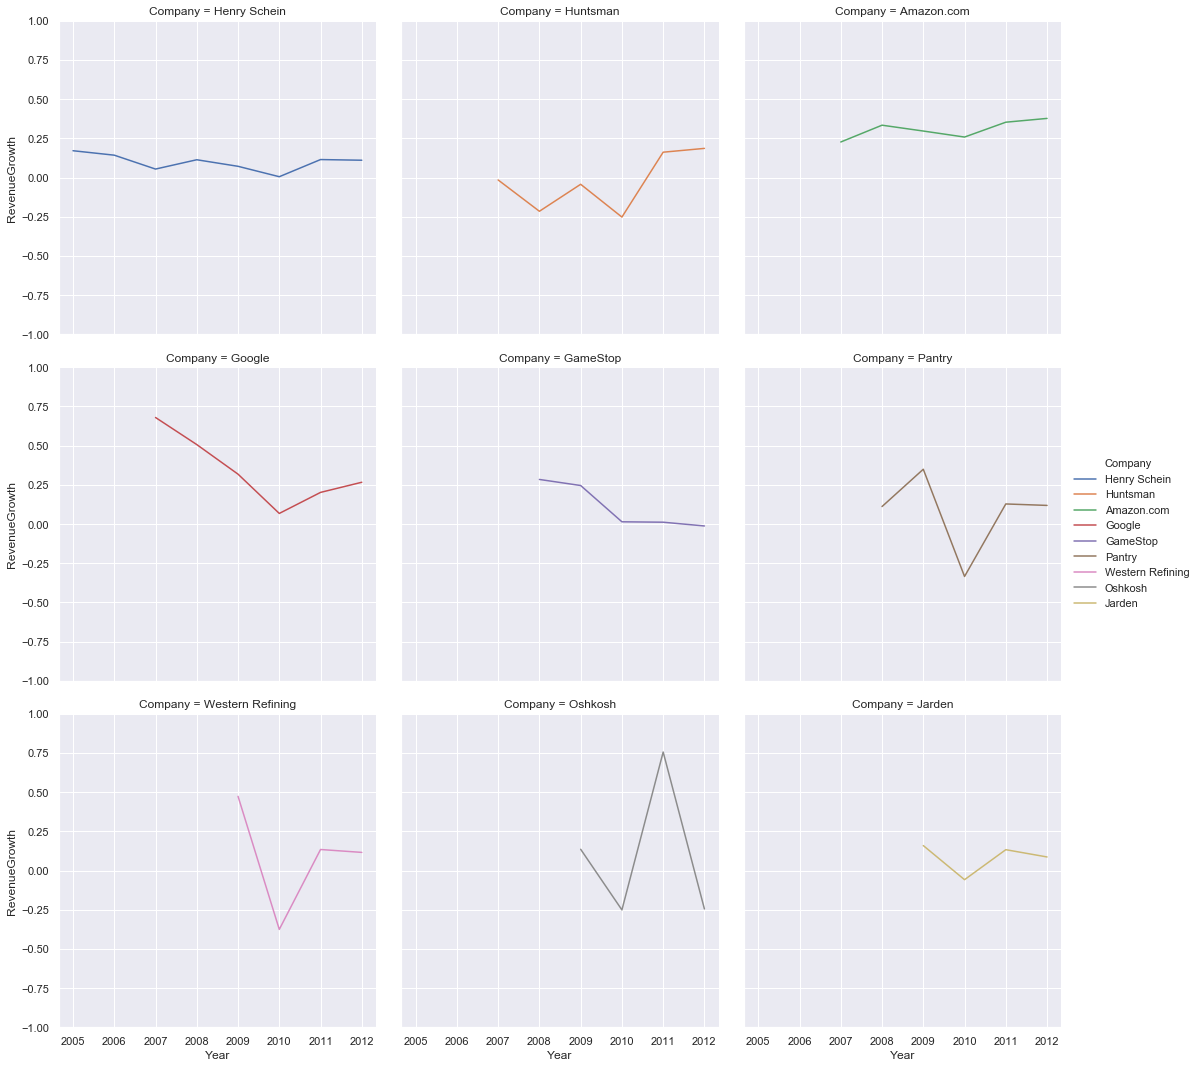

In [45]:
plt.figure(figsize=(16,8))
_ = sns.relplot(x="Year", y="RevenueGrowth", hue="Company", col="Company", col_wrap=3, data=by_6to10_2012, kind = "line")
g.fig.suptitle("Revenue Growth for 9 Sample Companies that lasted between 6-10 years, still in list ", fontsize=20)
plt.ylim(-1,1)

### Observation
#### Analysis of companies picked from 2 random years

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


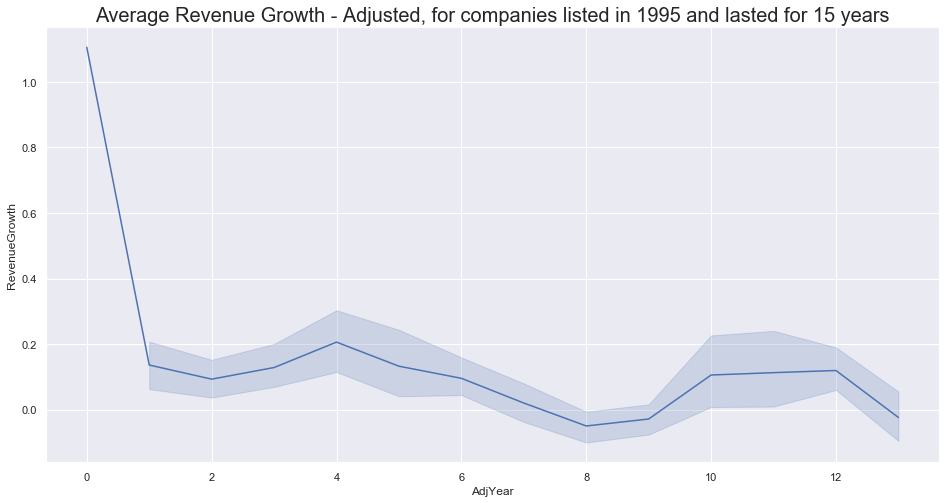

In [46]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="AdjYear", y="RevenueGrowth" , data=by_11to15_1995)\
        .set_title("Average Revenue Growth - Adjusted, for companies listed in 1995 and lasted for 15 years", \
                           fontsize=20)

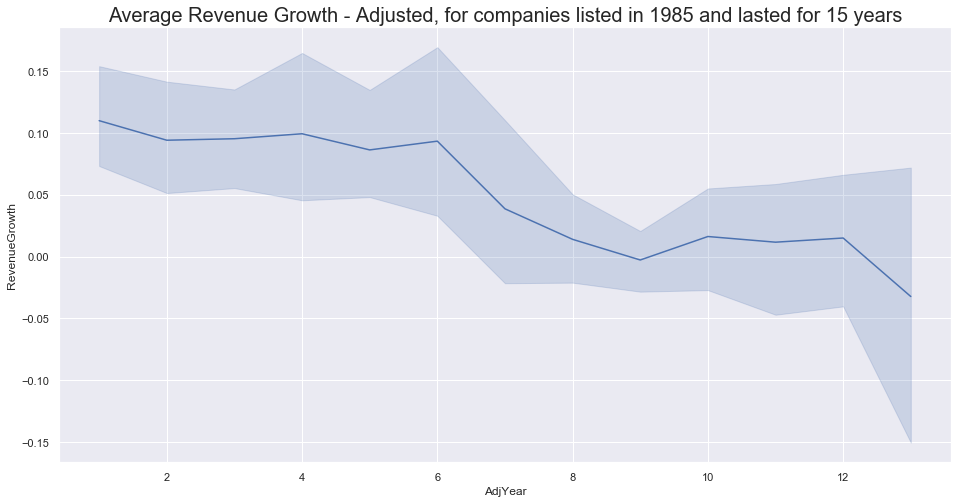

In [47]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="AdjYear", y="RevenueGrowth" , data=by_11to15_1985)\
        .set_title("Average Revenue Growth - Adjusted, for companies listed in 1985 and lasted for 15 years", \
                           fontsize=20)


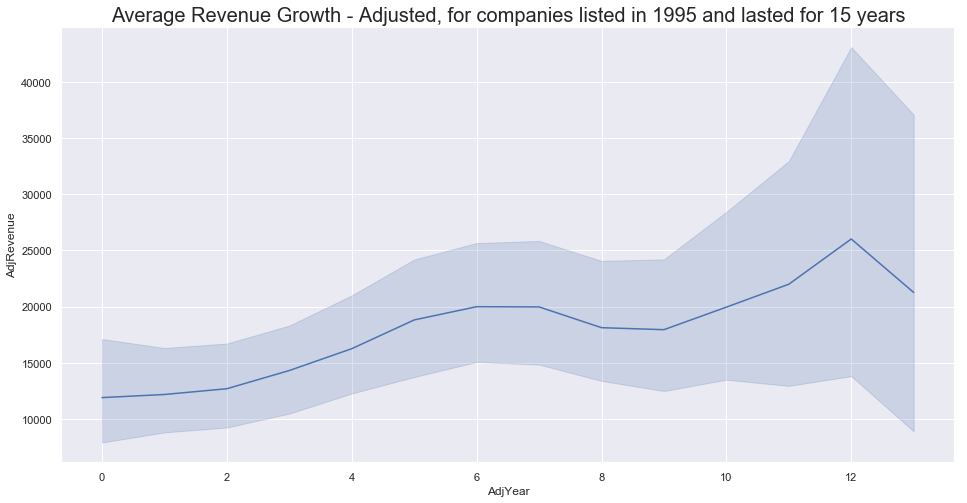

In [48]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="AdjYear", y="AdjRevenue" , data=by_11to15_1995)\
        .set_title("Average Revenue Growth - Adjusted, for companies listed in 1995 and lasted for 15 years", \
                           fontsize=20)

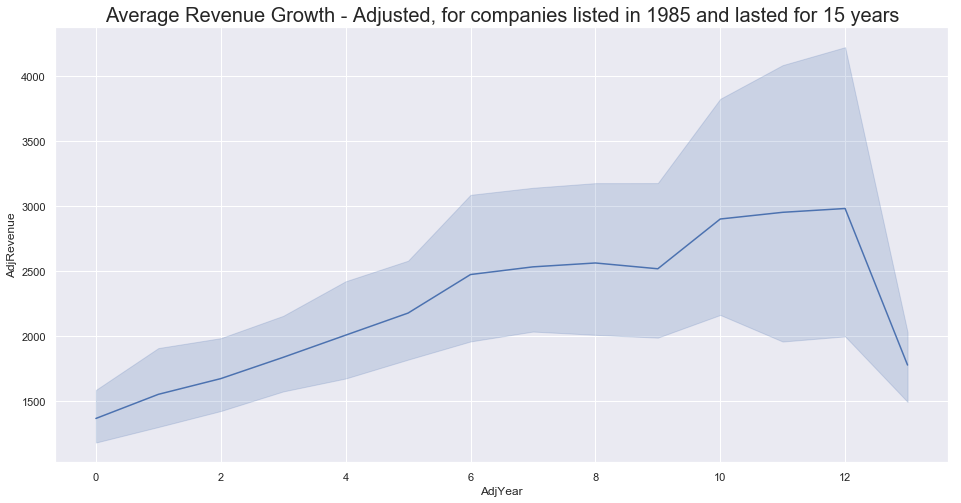

In [49]:
plt.figure(figsize=(16,8))
_ = sns.lineplot(x="AdjYear", y="AdjRevenue" , data=by_11to15_1985)\
        .set_title("Average Revenue Growth - Adjusted, for companies listed in 1985 and lasted for 15 years", \
                           fontsize=20)